# Проект "Парсинг данных о вакансиях с сайта hh.ru и исследование полученных данных"

<p align="center"><img src="https://gazon.media/userfls/news/large/2/11674_nayti-vakansiyu-mechty-kak-ts.png" width="600" height="400" /></p>

**Описание исследования:** Исследование ключевых характеристик вакансий с сайта hh.ru на позицию "Анатилик данных".

**Задача исследования:** Спарсить с сайта hh.ru данные о вакансиях на позицию "Анатилик данных", исследовать полученные данные.

**Используемые инструменты:** Python (requests, BeautifulSoup, fake_useragent, time, json (парсинг данных), pandas (создание новых столбцов в датасете (работа со строковыми данными, выделение отдельных слов/фраз), создание таблиц, работа с пропусками, типами данных, группировка), seaborn, matplotlib (визуалиция данных: построение графиков))

**Результат:** Получены сведения о 241 вакансии на позицию "Аналитик данных", проведено исследование данных:
- динамика количества публикаций вакансий в день;
- размер зарплаты, в том числе в зависимости от опыта работы, графика работы, навыков (SQL, Python, Excel), города публикации вакансии;
- распредление количества вакансий в зависимости от опыта работы, занятости (полный рабочий день, удалённая работа), графика работы, навыков (SQL, Python, Excel), города публикации вакансии.

Данные взяты с сайта hh.ru.

Парсинг с сайта hh.ru проводился 26.01.2024 в Visual Studio Code (VSC), в Jupyter Notebook осуществлялся исследовательский анализ данных.

In [ ]:
# импортируемые необходимые библиотеки для парсинга
import requests
from bs4 import BeautifulSoup
import fake_useragent
import time
import json

In [1]:
# импортируемые необходимые библиотеки для анализа данных (EDA)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Парсинг данных.

Напишем несколько функций. Первая - для получения ссылок на вакансии.

In [ ]:
def get_links(text_1, text_2):
    """Функция для получения ссылок на вакансии
    в соответствии с подаваемыми в неё ключевыми словами"""
    
    ua = fake_useragent.UserAgent() # для передачи заголовка
    data = requests.get(
        url=f"https://hh.ru/search/vacancy?L_save_area=true&text={text_1}+{text_2}&search_field\
        =name&excluded_text=&area=113&salary=&currency_code=RUR&experience=doesNotMatter&order_by=\
        relevance&search_period=0&items_on_page=50&page=1",
        
        headers={"user-agent":ua.random} # создаём заголовок, передаём ему случайный заголовок из созданного объекта
    )
    
    if data.status_code != 200: # то есть, если код обработки запроса не 200 (есть ошибки), то выходим из функции
        return
    
    soup = BeautifulSoup(data.content, "lxml") # передаём контент страницы
    
    try:
        page_count = int(soup.find("div", attrs={"class":"pager", "data-qa":"pager-block"})\
                         .find_all("span", recursive=False)[-1].find("a").find("span").text)
        # считаем количество страниц в соответствующем поисковом запросе на сайте
    except:
        return
    
    for page in range(page_count): # проходим циклом по каждой странице, чтобы получить ссылки на вакансии
        try:   
            data = requests.get(
                url=f"https://hh.ru/search/vacancy?L_save_area=true&text={text_1}+{text_2}&search_field=\
                name&excluded_text=&area=113&salary=&currency_code=RUR&experience=doesNotMatter&order_by=\
                relevance&search_period=0&items_on_page=50&page={page}",
                
                headers={"user-agent":ua.random} # создаём заголовок, передаём ему случайный заголовок из созданного объекта
                )
            
            if data.status_code != 200:
                continue
                
            soup = BeautifulSoup(data.content, "lxml") # считываем контент страницы
            
            for a in soup.find_all("a",attrs={"class":"bloko-link", "target":"_blank"}):
                yield f"{a.attrs['href'].split('?')[0]}"
                    
        except: # если не получается получить данные, функция начинает заново работать через 5 секунд
            print("Connection refused by the server..")
            time.sleep(5)
            continue
        time.sleep(3)

Вторая функция - для получения данных о вакансиях.

In [ ]:
def get_vacancy(link):
    """Функция для получения сведениях о вакансиях"""
    
    ua = fake_useragent.UserAgent() # для передачи заголовка
    data = requests.get(
        url=link,
        headers={"user-agent":ua.random} # создаём заголовок, передаём ему случайный заголовок из созданного объекта
    )
    
    if data.status_code != 200: # то есть, если код обработки запроса не 200 (есть ошибки), то выходим из функции
        return
    
    soup = BeautifulSoup(data.content,"lxml") # передаём контент страницы
    
    # выбираем сведения о вакансиях
    # наименование вакансии
    try:
        name = soup.find(attrs={"class":"vacancy-title"}).text.replace("от"," от ").replace("до"," до ")
    except:
        name = ""
    # зарплата
    try:
        salary = soup.find(attrs={"data-qa":"vacancy-salary-compensation-type-net"}).text.replace("\xa0","")
    except:
        salary = ""
    # опыт работы
    try:
        experience = soup.find(attrs={"class":"vacancy-description-list-item"}).text.replace("Требуемый опыт работы: ","")
    except:
        experience = ""
    # режим работы
    try:
        schedule = soup.find(attrs={"class":"vacancy-description-list-item", "data-qa":"vacancy-view-employment-mode"}).text
    except:
        schedule = ""
    # требуемые навыки
    try:
        skills = [skills.text for skills in soup.find(attrs={"class":"bloko-tag-list"})\
                                                    .find_all(attrs={"class":"bloko-tag__section bloko-tag__section_text",\
                                                    "data-qa":"bloko-tag__text"})]
    
    except:
        skills = ""
    # адрес
    try:
        address = soup.find(attrs={"data-qa":"vacancy-address-with-map", "class":"bloko-text bloko-text_large"}).text
    
    except:
        address = ""
    # дата публикации вакансии
    try:
        vacancy_date = soup.find(attrs={"class":"vacancy-creation-time-redesigned"}).text.replace("Вакансия опубликована ","")\
        .replace("\xa0"," ")
    
    except:
        vacancy_date = ""
    
    vacancy = {
        "name":name,
        "salary":salary,
        "experience":experience,
        "schedule":schedule,
        "skills":skills,
        "address":address,
        "vacancy_date":vacancy_date
        }
    return vacancy

Применяем напишенные выше функции для получения данных по вакансиям.

In [ ]:
data = [] # создаём объект
for a in get_links("аналитик", "данных"): # вызываем функцию для получения ссылок на вакансии
    string = "//hh.ru" # ограничиваем выдачу только вакансиями
    if string in a:
        data.append(get_vacancy(a)) # если вакансия соответствует описанию, добавляем в объект data
        time.sleep(3)
        with open("data.json", "w", encoding="utf-8") as f: # переносим объект data в json
            json.dump(data,f,indent=4,ensure_ascii=False)

Читаем полученный файл .json, записываем в файл формата .csv. 

In [ ]:
data = pd.read_json("....json")
data.to_csv('data_vacancies_1.csv', encoding='utf-8', index=False)

## Предобработка данных.

Загрузим датасет и посмотрим на данные с помощью метода head().

In [2]:
hh_parsing_vacancies = pd.read_csv("....csv")

In [3]:
hh_parsing_vacancies.head()

,name,salary,experience,schedule,skills,address,vacancy_date
0,Аналитик данных от 80 000 ₽ до вычета налогов,NaN,1–3 года,"Полная занятость, полный день","['Анализ данных', 'MS PowerPoint', 'Аналитичес...","Долгопрудный, Институтский переулок, 7",26 января 2024 в Москве
1,Аналитик данных,NaN,1–3 года,"Полная занятость, гибкий график",NaN,"Москва, Воронцовская улица, 5с2",26 января 2024 в Москве
2,Аналитик данных,NaN,не требуется,"Полная занятость, полный день","['Credit Registry', 'БКИ', 'MS SQL Server', 'M...",NaN,26 января 2024 в Москве
3,Аналитик данных,NaN,1–3 года,"Полная занятость, полный день","['Python', 'Аналитическое мышление', 'Сбор и а...","Москва, Кунцевская, Кунцевская, Славянский бул...",26 января 2024 в Москве
4,Аналитик данных от 100 000 до 200 000 ₽ до...,NaN,3–6 лет,"Полная занятость, полный день","['Аналитическое мышление', 'Python', 'Математи...","Москва, Серпуховская, Партийный переулок, 1к57с1",26 января 2024 в Москве


In [4]:
hh_parsing_vacancies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          241 non-null    object
 1   salary        31 non-null     object
 2   experience    241 non-null    object
 3   schedule      241 non-null    object
 4   skills        141 non-null    object
 5   address       121 non-null    object
 6   vacancy_date  241 non-null    object
dtypes: object(7)
memory usage: 13.3+ KB


Сначала проверим данные на дубликаты.

In [5]:
hh_parsing_vacancies.duplicated().sum()

0

Дубликатов вакансий нет, перейдём к подготовке данных к их исследованию.

Исследование данных будем проводить по следующим пунктам:
- размер зарплаты;
- требуемый опыт работы;
- полная или частичная занятость;
- полный день или удалённая работа;
- как часто требуется знание SQL, Python, Excel, английского, математической статистики;
- динамика количества публикаций вакансий по дням.
    
Для этого создадим дополнительные столбцы.

### Создание дополнительных столбцов: зарплата.

Начнём с данных о зарплате. Посмотрим уникальные данные по этому столбцу.

In [6]:
hh_parsing_vacancies.salary.unique()

array([nan, 'от 50000 ₽ на руки', 'до 80000 ₽ на руки',
       'от 70000 до 95000 ₽ на руки', 'до 108000 ₽ на руки',
       'от 75000 до 85000 ₽ на руки', 'от 35000 до 350000 ₽ на руки',
       'до 100000 ₽ на руки', 'до 250000 ₽ на руки',
       'от 100000 ₽ на руки', 'от 110000 до 120000 ₽ на руки',
       'до 120000 ₽ на руки', 'от 40000 ₽ на руки', 'от 150000 ₽ на руки',
       'до 350000 ₽ на руки', 'от 70000 до 140000 ₽ на руки',
       'от 35000 до 80000 ₽ на руки', 'от 70000 ₽ на руки',
       'от 100000 до 140000 ₽ на руки', 'от 70000 до 70000 ₽ на руки',
       'до 130000 ₽ на руки', 'от 80000 ₽ на руки',
       'от 110000 до 150000 ₽ на руки', 'до 300000 ₽ на руки',
       'от 60000 ₽ на руки', 'от 45000 до 50000 ₽ на руки'], dtype=object)

Для анализа в отдельном столбце переведём данные в соответствующий вид: оставим только значение нижней границы предлагаемой зарплаты (то есть избавимся от слов и верхней границы зарплаты).

In [7]:
hh_parsing_vacancies['salary_new'] = hh_parsing_vacancies['salary'].str.extract('(\d+)')

Проверим, как прошло преобразование данных о зарплате.

In [8]:
hh_parsing_vacancies.salary_new.unique()

array([nan, '50000', '80000', '70000', '108000', '75000', '35000',
       '100000', '250000', '110000', '120000', '40000', '150000',
       '350000', '130000', '300000', '60000', '45000'], dtype=object)

Кроме того, в некоторых вакансиях зарплата не указана в нужном столбце, а указана в наименовании вакансии. Создадим столбец с данными по зарплате из наименований вакансий, потом объединим 2 столбца (salary_new и новый столбец из наименований вакансий) в новый общий (итоговый) столбец.

In [9]:
hh_parsing_vacancies.loc[hh_parsing_vacancies['salary'].isnull()].name.unique()

array(['Аналитик данных от  80\xa0000 ₽  до  вычета налогов',
       'Аналитик данных',
       'Аналитик данных от  100\xa0000  до  200\xa0000 ₽  до  вычета налогов',
       'Аналитик данных от  260\xa0000  до  300\xa0000 ₽  до  вычета налогов',
       'Аналитик (Визуализация данных)',
       'Аналитик базы данных от  92\xa0000  до  100\xa0280 ₽  до  вычета налогов',
       'Аналитик данных от  130\xa0000  до  150\xa0000 ₽  до  вычета налогов',
       'Аналитик по обраб от ке данных со знанием SPSS',
       'Аналитик данных на маркетплейсах/аналитик BI от  115\xa0000  до  170\xa0000 ₽  до  вычета налогов',
       'Аналитик в Отдел разраб от ки инструментов и аналитики данных',
       'Аналитик данных (анализ обращений клиентов) от  35\xa0000  до  40\xa0000 ₽  до  вычета налогов',
       'Data analyst / Аналитик данных',
       'Junior Python-разраб от чик (Аналитика данных)',
       'Главный бизнес-аналитик (качество данных\\Data quality)',
       'Аналитик данных/Системный аналитик',


Данные по зарплате записаны в некорректном виде: например, "от  80\xa0000 ₽  до  вычета налогов". Приведём значение зарплаты в надлежащий вид:  "от  80000 ₽  до  вычета налогов".

In [10]:
hh_parsing_vacancies['name'] = hh_parsing_vacancies['name'].str.replace('\xa0','')

Теперь в новый вспомогательный столбец вынесем данные по зарплате из столбца с наименованиями вакансий.

In [11]:
hh_parsing_vacancies['salary_new_from_name'] = hh_parsing_vacancies.loc[hh_parsing_vacancies['salary'].isnull()]\
['name'].str.extract('(\d+)')

Сольём в итоговый общий столбец данные по зарплате.

In [12]:
hh_parsing_vacancies['salary_total'] = hh_parsing_vacancies['salary_new'].fillna(hh_parsing_vacancies['salary_new_from_name'])

Проверим, как прошло создание нового столбца (не потеряли ли мы данные по зарплате).

Сначала, выведем строки, где столбец salary не пустой (то есть, где изначально в вакансиях заполнена данная графа).

In [13]:
hh_parsing_vacancies.loc[(hh_parsing_vacancies['salary'].notnull())&(hh_parsing_vacancies['salary_total'].notnull())].T

,5,8,15,16,35,50,56,57,63,64,...,146,148,151,152,154,161,166,176,184,221
name,Аналитик данных от 50000 ₽ на руки,Аналитик данных/бизнес аналитик до 80000 ₽ на...,Аналитик данных от 70000 до 95000 ₽ на руки,Аналитик (качество данных) до 108000 ₽ на руки,Консультант от дела данных рынка труда (Анали...,Аналитик данных (рекламный) от 35000 до 350...,Аналитик данных/специалист Excel (удалённо) от...,Аналитик данных/Data analyst (фармацевтическое...,Продуктовый аналитик / аналитик данных / CVM /...,Аналитик данных/разраб от чик (BI - аналитик) ...,...,Аналитик данных ( Баинг ) от 70000 ₽ на руки,Аналитик данных POWER BI от 100000 до 14000...,BI-аналитик / аналитик данных до 120000 ₽ на ...,Аналитик данных от 70000 до 70000 ₽ на руки,Аналитик данных/Data analyst (фармацевтическое...,Маркетолог-аналитик данных фарм от расли от 8...,Аналитик данных от 110000 до 150000 ₽ на руки,Аналитик данных до 300000 ₽ на руки,Бизнес аналитик (аналитик данных) от 60000 ₽ ...,Аналитик данных от 45000 до 50000 ₽ на руки
salary,от 50000 ₽ на руки,до 80000 ₽ на руки,от 70000 до 95000 ₽ на руки,до 108000 ₽ на руки,от 75000 до 85000 ₽ на руки,от 35000 до 350000 ₽ на руки,от 50000 ₽ на руки,до 100000 ₽ на руки,до 250000 ₽ на руки,от 100000 ₽ на руки,...,от 70000 ₽ на руки,от 100000 до 140000 ₽ на руки,до 120000 ₽ на руки,от 70000 до 70000 ₽ на руки,до 130000 ₽ на руки,от 80000 ₽ на руки,от 110000 до 150000 ₽ на руки,до 300000 ₽ на руки,от 60000 ₽ на руки,от 45000 до 50000 ₽ на руки
experience,1–3 года,1–3 года,3–6 лет,1–3 года,3–6 лет,не требуется,1–3 года,1–3 года,1–3 года,1–3 года,...,1–3 года,1–3 года,1–3 года,1–3 года,1–3 года,1–3 года,1–3 года,1–3 года,не требуется,не требуется
schedule,"Полная занятость, полный день","Полная занятость, полный день","Частичная занятость, удаленная работа","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа","Полная занятость, удаленная работа","Полная занятость, удаленная работа","Полная занятость, удаленная работа","Полная занятость, удаленная работа",...,"Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день"
skills,"['Работа с большим объемом информации', 'Excel...","['SaaS', 'MS SQL', 'Power BI', 'Qlik-Sense', '...",['Английский\xa0— A1 — Начальный'],"['SQL', 'Python', 'MS Office']","['Сбор и анализ информации', 'Подготовка отчет...","['Анализ данных', 'Аналитическое мышление', 'А...","['Пользователь ПК', 'Работа в команде', 'Грамо...","['SQL', 'Python', 'Работа с базами данных', 'А...","['SQL', 'Python', 'A/B тесты', 'ML', 'Power BI...",['Английский\xa0— A1 — Начальный'],...,NaN,NaN,NaN,NaN,"['SQL', 'Python', 'Работа с базами данных', 'А...",NaN,NaN,"['Data Analysis', 'SQL']",NaN,"['Английский язык', 'Работа с большим объемом ..."
address,"Москва, Крестьянская застава, Павелецкая, Прол...",NaN,NaN,"Санкт-Петербург, Выборгская, Лесная, Большой С...","Москва, Сретенский бульвар, Тургеневская, Чист...",NaN,"Санкт-Петербург, Московская, площадь Конституц...",NaN,NaN,NaN,...,NaN,"Новосибирск, площадь им. Карла Маркса, 7","Владивосток, Русская улица, 94А","Самара, Московское шоссе, 264А","Москва, 2-я Звенигородская улица, 13с43",NaN,"Ростов-на-Дону, проспект Соколова, 62",NaN,NaN,"Екатеринбург, Площадь 1905 года, улица Антона ..."
vacancy_date,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Санкт-Петербурге,26 января 2024 в Москве,25 января 2024 в Санкт-Петербурге,25 января 2024 в Санкт-Петербурге,25 января 2024 в Екатеринбурге,25 января 2024 в Москве,24 января 2024 в Москве,...,15 января 2024 в Москве,26 января 2024 в Новосибирске,15 января 2024 в городе Владивостоке,12 января 2024 в Самаре,17 января 2024 в Москве,15 января 2024 в Екатеринбурге,10 января 2024 в Ростове-н

Здесь данные не потеряны: 31 строка с данными по зарплате, как и было изначально в датасете.

Теперь выведем строки, где столбец salary пустой (то есть, где изначально в вакансиях не заполнена данная графа).

In [14]:
hh_parsing_vacancies.loc[(hh_parsing_vacancies['salary'].isnull())&(hh_parsing_vacancies['salary_total'].notnull())].T

,0,4,7,18,20,23,26,38,41,48,...,94,97,102,110,122,130,205,223,231,239
name,Аналитик данных от 80000 ₽ до вычета налогов,Аналитик данных от 100000 до 200000 ₽ до ...,Аналитик данных от 260000 до 300000 ₽ до ...,Аналитик базы данных от 92000 до 100280 ₽ ...,Аналитик данных от 130000 до 150000 ₽ до ...,Аналитик данных на маркетплейсах/аналитик BI о...,Аналитик данных (анализ обращений клиентов) от...,Аналитик данных от 300000 ₽ до вычета налогов,"Аналитик маркетинговых данных, удаленно от 90...",Аналитик данных (анализ обращений клиентов) от...,...,Аналитик данных (закупки 44-223-ФЗ),Стажер Аналитик данных/DWH до 30000 ₽ до вы...,Младший аналитик от дела данных рынка труда о...,Аналитик на DWH/витрины данных (клиент 360),Ведущий экономист-аналитик баз данных (анализ ...,Аналитик данных от 200000 ₽ до вычета налогов,Начинающий аналитик / Специалист по сбору и об...,Аналитик данных по направлению взыскания (моде...,BI - разраб от чик (аналитик данных) до 20000...,Аналитик баз данных от 100000 ₽ до вычета н...
salary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
experience,1–3 года,3–6 лет,3–6 лет,1–3 года,1–3 года,3–6 лет,не требуется,1–3 года,3–6 лет,не требуется,...,1–3 года,не требуется,1–3 года,3–6 лет,3–6 лет,1–3 года,не требуется,1–3 года,1–3 года,не требуется
schedule,"Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа","Полная занятость, полный день",...,"Полная занятость, полный день","Стажировка, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день"
skills,"['Анализ данных', 'MS PowerPoint', 'Аналитичес...","['Аналитическое мышление', 'Python', 'Математи...",NaN,"['MS Excel', 'Работа с базами данных', 'Точнос...","['Python', 'MS PowerPoint', 'Аналитика', 'Сбор...",NaN,NaN,"['Анализ данных', 'SQL', 'Аналитика', 'Работа ...","['Анализ данных', 'Работа с базами данных', 'А...",NaN,...,"['PostgreSQL', 'Power BI', 'Сбор и анализ инфо...","['SQL', 'Python']","['Анализ данных', 'Грамотная речь', 'Ориентаци...","['SQL', 'DWH', 'PostgreSQL', 'Витрины данных',...","['Работа с большим объемом информации', 'Точно...",NaN,"['Работа с большим объемом информации', 'Англи...",NaN,"['SQL', 'Анализ данных', 'Power BI', 'SSAS', '...",NaN
address,"Долгопрудный, Институтский переулок, 7","Москва, Серпуховская, Партийный переулок, 1к57с1",NaN,"Москва, Сокол, Волоколамское шоссе, 1с1",NaN,NaN,"Ставрополь, проспект Кулакова, 83Б",NaN,NaN,"Ставрополь, проспект Кулакова, 83Б",...,"Москва, Чистопрудный бульвар, 17с1",NaN,"Москва, Сретенский бульвар, Тургеневская, Чист...",NaN,NaN,"Москва, Павелецкая, Павелецкая, Космодамианска...",NaN,"Москва, Люсиновская улица, 27с1Б","109316, Москва г, Волгоградский пр-кт, дом № 4...","Москва, улица Академика Опарина, 4"
vacancy_date,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,25 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Ставрополе,25 января 2024 в Москве,25 января 2024 в Москве,25 января 2024 в Ставрополе,...,23 января 2024 в Москве,22 января 2024 в Санкт-Петербурге,22 января 2024 в Москве,22 января 2024 в Москве,22 января 2024 в Москве,15 января 2024 в Москве,16 января 2024 в Москве,10 января 2024 в Москве,5 января 2024 в Москве,12 января 2024 в Москве
salary_new,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_new_from_name,80000,100000,260000,92000,130000,115000,35000,300000,90000,35000,...,44,30000,60000,360,81000,200000,50000,150000,200000,100000
salary_total,80000,100000,260000,92000,130000,115000,350

Таким образом, прибавлено 25 строк. То есть, мы увеличили долю сведений по зарплате на 80% (было 31 строка с зп, стало 56 строк (31+25)).

Теперь заполним пустые значения "заглушкой" (-100) и переведём тип данных с object в integer.

In [15]:
hh_parsing_vacancies['salary_total'] = hh_parsing_vacancies['salary_total'].fillna(-100)

Изменим тип данных в столбце salary_total (зарплата).

In [16]:
hh_parsing_vacancies['salary_total'] = hh_parsing_vacancies['salary_total'].astype(int)

Проверим, как прошло изменение типа данных.

In [17]:
hh_parsing_vacancies['salary_total'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 241 entries, 0 to 240
Series name: salary_total
Non-Null Count  Dtype
--------------  -----
241 non-null    int32
dtypes: int32(1)
memory usage: 1.1 KB


Посмотрим на уникальные данные по зарплате.

In [18]:
hh_parsing_vacancies['salary_total'].unique()

array([ 80000,   -100, 100000,  50000, 260000,  70000, 108000,  92000,
       130000, 115000,  35000,  75000, 300000,  90000, 250000,  65000,
       200000,  45000,     44,  30000,  60000,    360, 110000, 120000,
        81000,  40000, 150000, 350000])

Есть данные, которые не относятся к зарплате: "44", "360". Посмотрим, что это за строки.

In [19]:
hh_parsing_vacancies.loc[(hh_parsing_vacancies['salary_total'] == 44)|\
                         (hh_parsing_vacancies['salary_total'] == 360)].T

,94,110
name,Аналитик данных (закупки 44-223-ФЗ),Аналитик на DWH/витрины данных (клиент 360)
salary,NaN,NaN
experience,1–3 года,3–6 лет
schedule,"Полная занятость, полный день","Полная занятость, полный день"
skills,"['PostgreSQL', 'Power BI', 'Сбор и анализ инфо...","['SQL', 'DWH', 'PostgreSQL', 'Витрины данных',..."
address,"Москва, Чистопрудный бульвар, 17с1",NaN
vacancy_date,23 января 2024 в Москве,22 января 2024 в Москве
salary_new,NaN,NaN
salary_new_from_name,44,360
salary_total,44,360


Эти данные не имеют отношения к зарплате, поэтому заменим их на "заглушку", чтобы не учитывать при расчётах.

In [20]:
hh_parsing_vacancies['salary_total'] = hh_parsing_vacancies['salary_total'].replace(44,-100).replace(360,-100)

In [21]:
hh_parsing_vacancies.loc[[94,110]].T

,94,110
name,Аналитик данных (закупки 44-223-ФЗ),Аналитик на DWH/витрины данных (клиент 360)
salary,NaN,NaN
experience,1–3 года,3–6 лет
schedule,"Полная занятость, полный день","Полная занятость, полный день"
skills,"['PostgreSQL', 'Power BI', 'Сбор и анализ инфо...","['SQL', 'DWH', 'PostgreSQL', 'Витрины данных',..."
address,"Москва, Чистопрудный бульвар, 17с1",NaN
vacancy_date,23 января 2024 в Москве,22 января 2024 в Москве
salary_new,NaN,NaN
salary_new_from_name,44,360
salary_total,-100,-100


Удалим вспомогательные столбцы (salary_new, salary_new_from_name), как лишние.

In [22]:
hh_parsing_vacancies = hh_parsing_vacancies.drop(columns=['salary_new','salary_new_from_name'])

### Создание дополнительных столбцов: опыт работы.

Теперь перейдем к данным по требуемому опыту работы. Посмотрим уникальные значения столбца experience.

In [23]:
hh_parsing_vacancies.experience.unique()

array(['1–3 года', 'не требуется', '3–6 лет', 'более 6 лет'], dtype=object)

Здесь преобразовывать данные не нужно.

### Создание дополнительных столбцов: занятость и дистанционная работа.

In [24]:
hh_parsing_vacancies.schedule.unique()

array(['Полная занятость, полный день', 'Полная занятость, гибкий график',
       'Полная занятость, удаленная работа',
       'Частичная занятость, удаленная работа', 'Стажировка, полный день'],
      dtype=object)

Разделим данные из столбца schedule на 2 столбца:
- занятость: полная, частичная, стажировка;
- режим работы: полный день, гибкий/сменный график, удалённая работа.

In [25]:
# создаём столбец с занятостью: полная, частичная, стажировка
hh_parsing_vacancies['time_job'] = hh_parsing_vacancies['schedule']\
.apply(lambda x: x.split(", ")[0] if type(x) == str else str(x))

# создаём столбец с графиком: полный день, гибкий/сменный график, удалённая работа
hh_parsing_vacancies['distant'] = hh_parsing_vacancies['schedule']\
.apply(lambda x: x.split(", ")[-1] if type(x) == str else str(x))

Проверим, какие уникальные данные содержатся в новых столбцах. 

In [26]:
hh_parsing_vacancies.time_job.unique()

array(['Полная занятость', 'Частичная занятость', 'Стажировка'],
      dtype=object)

In [27]:
hh_parsing_vacancies.distant.unique()

array(['полный день', 'гибкий график', 'удаленная работа'], dtype=object)

### Создание дополнительных столбцов: навыка (skills).

Перейдём к требуемым навыкам: как часто требуется знание SQL, Python, Excel, английского, математической статистики. Создадим отдельные столбцы по каждому выбранному навыку.

Создадим функцию для создания таких столбцов.

In [28]:
def create_skill(base_column, text):
    """Функция для создания столбцов по отдельному навыку"""
    new_column = base_column.str.contains(text)
    return new_column

In [29]:
hh_parsing_vacancies['SQL'] = create_skill(hh_parsing_vacancies['skills'], 'SQL')
hh_parsing_vacancies['Python'] = create_skill(hh_parsing_vacancies['skills'], 'Python')
hh_parsing_vacancies['Excel'] = create_skill(hh_parsing_vacancies['skills'], 'Excel')
hh_parsing_vacancies['English'] = create_skill(hh_parsing_vacancies['skills'], 'нглийск')
hh_parsing_vacancies['Math'] = create_skill(hh_parsing_vacancies['skills'], 'татистика')

Посмотрим, как прошло создание столбцов по отдельным навыкам.

In [30]:
hh_parsing_vacancies.head().T

,0,1,2,3,4
name,Аналитик данных от 80000 ₽ до вычета налогов,Аналитик данных,Аналитик данных,Аналитик данных,Аналитик данных от 100000 до 200000 ₽ до ...
salary,NaN,NaN,NaN,NaN,NaN
experience,1–3 года,1–3 года,не требуется,1–3 года,3–6 лет
schedule,"Полная занятость, полный день","Полная занятость, гибкий график","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день"
skills,"['Анализ данных', 'MS PowerPoint', 'Аналитичес...",NaN,"['Credit Registry', 'БКИ', 'MS SQL Server', 'M...","['Python', 'Аналитическое мышление', 'Сбор и а...","['Аналитическое мышление', 'Python', 'Математи..."
address,"Долгопрудный, Институтский переулок, 7","Москва, Воронцовская улица, 5с2",NaN,"Москва, Кунцевская, Кунцевская, Славянский бул...","Москва, Серпуховская, Партийный переулок, 1к57с1"
vacancy_date,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве
salary_total,80000,-100,-100,-100,100000
time_job,Полная занятость,Полная занятость,Полная занятость,Полная занятость,Полная занятость
distant,полный день,гибкий график,полный день,полный день,полный день


### Создание дополнительных столбцов: дата публикации вакансии.

Теперь выделим дату из столбца vacancy_date (дата публикации вакансии).

In [31]:
hh_parsing_vacancies['vacancy_date_new'] = hh_parsing_vacancies['vacancy_date']\
.apply(lambda x: x.split(" в")[0] if type(x) == str else str(x))

Посмотрим, как прошло создание нового столбца.

In [32]:
hh_parsing_vacancies['vacancy_date_new'].unique()

array(['26 января 2024', '25 января 2024', '24 января 2024',
       '23 января 2024', '22 января 2024', '21 января 2024',
       '18 января 2024', '19 января 2024', '17 января 2024',
       '16 января 2024', '15 января 2024', '12 января 2024',
       '10 января 2024', '9 января 2024', '14 января 2024',
       '11 января 2024', '6 января 2024', '8 января 2024',
       '5 января 2024', '4 января 2024', '29 декабря 2023',
       '28 декабря 2023', '13 января 2024'], dtype=object)

Здесь видно, что даты в требуемом для анализа виде: например, у нас вместо "январь" стоит "января". Поэтому, сначала в отдельные столбцы выделим день, месяц, год, затем заменим месяцы, соединим в новый столбец. И сразу поменяем тип данных с object на datetime.

In [33]:
# создаём столбец с годом
hh_parsing_vacancies['year'] = hh_parsing_vacancies['vacancy_date_new']\
.apply(lambda x: x.split(' ')[-1] if type(x) == str else str(x))

# создаём столбец с порядковым номером дня
hh_parsing_vacancies['day'] = hh_parsing_vacancies['vacancy_date_new']\
.apply(lambda x: x.split(' ')[0] if type(x) == str else str(x)).replace('4','04').replace('5','05')\
.replace('6','06').replace('8','08').replace('9','09')

# создаём столбец с месяцем
hh_parsing_vacancies['month'] = hh_parsing_vacancies['vacancy_date_new']\
.apply(lambda x: x.split(' ')[1] if type(x) == str else str(x)).replace('декабря','dec').replace('января','jan')

# создаём столбец с датой на основе 3-х столбцов
hh_parsing_vacancies['date'] = hh_parsing_vacancies[['day','month','year']].agg('/'.join, axis=1)

# меняем тип полученного столбца с object на datetime
hh_parsing_vacancies['date'] = pd.to_datetime(hh_parsing_vacancies['date'])

# удаляем лишние столбцы
hh_parsing_vacancies = hh_parsing_vacancies.drop(columns=['year','day','month','vacancy_date_new'])

Посмотрим, как прошло создание нового столбца с датой публикации вакансий, а также тип данных этого столбца.

In [34]:
hh_parsing_vacancies.head().T

,0,1,2,3,4
name,Аналитик данных от 80000 ₽ до вычета налогов,Аналитик данных,Аналитик данных,Аналитик данных,Аналитик данных от 100000 до 200000 ₽ до ...
salary,NaN,NaN,NaN,NaN,NaN
experience,1–3 года,1–3 года,не требуется,1–3 года,3–6 лет
schedule,"Полная занятость, полный день","Полная занятость, гибкий график","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день"
skills,"['Анализ данных', 'MS PowerPoint', 'Аналитичес...",NaN,"['Credit Registry', 'БКИ', 'MS SQL Server', 'M...","['Python', 'Аналитическое мышление', 'Сбор и а...","['Аналитическое мышление', 'Python', 'Математи..."
address,"Долгопрудный, Институтский переулок, 7","Москва, Воронцовская улица, 5с2",NaN,"Москва, Кунцевская, Кунцевская, Славянский бул...","Москва, Серпуховская, Партийный переулок, 1к57с1"
vacancy_date,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве
salary_total,80000,-100,-100,-100,100000
time_job,Полная занятость,Полная занятость,Полная занятость,Полная занятость,Полная занятость
distant,полный день,гибкий график,полный день,полный день,полный день


In [35]:
hh_parsing_vacancies.date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 241 entries, 0 to 240
Series name: date
Non-Null Count  Dtype         
--------------  -----         
241 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.0 KB


### Создание дополнительных столбцов: город публикации вакансии.

Для оценки месторасположения работодателя создадим столбец city на основе столбца vacancy_date (дата публикации вакансии).

In [36]:
hh_parsing_vacancies['city'] = hh_parsing_vacancies['vacancy_date']\
.apply(lambda x: x.split(' в ')[-1] if type(x) == str else str(x))

Проверим, как прошло создание нового столбца.

In [37]:
hh_parsing_vacancies['city'].unique()

array(['Москве', 'Санкт-Петербурге', 'Чебоксарах', 'Екатеринбурге',
       'Краснодаре', 'Ставрополе', 'Нижнем Новгороде', 'Анапе',
       'Барнауле', 'городе Владивостоке', 'Иваново', 'Курске', 'Тюмени',
       'Самаре', 'Казани', 'Новосибирске', 'Симферополе', 'Златоусте',
       'Комсомольске-на-Амуре', 'Находке', 'Благовещенске',
       'городе Владимире', 'Пскове', 'Ижевске', 'Ростове-на-Дону',
       'Якутске'], dtype=object)

Уберём слово "город" там, где оно встречается.

In [38]:
hh_parsing_vacancies['city'] = hh_parsing_vacancies['city'].str.replace('городе ','')

In [39]:
hh_parsing_vacancies['city'].unique()

array(['Москве', 'Санкт-Петербурге', 'Чебоксарах', 'Екатеринбурге',
       'Краснодаре', 'Ставрополе', 'Нижнем Новгороде', 'Анапе',
       'Барнауле', 'Владивостоке', 'Иваново', 'Курске', 'Тюмени',
       'Самаре', 'Казани', 'Новосибирске', 'Симферополе', 'Златоусте',
       'Комсомольске-на-Амуре', 'Находке', 'Благовещенске', 'Владимире',
       'Пскове', 'Ижевске', 'Ростове-на-Дону', 'Якутске'], dtype=object)

Перейдём к работе с пропущенными данными.

### Работа с пропущенными значениями.

В части столбцов отсутствуют данные, посмотрим количество пропущенных значений в столбцах датасета.

In [40]:
hh_parsing_vacancies.isnull().sum() 

name              0
salary          210
experience        0
schedule          0
skills          100
address         120
vacancy_date      0
salary_total      0
time_job          0
distant           0
SQL             100
Python          100
Excel           100
English         100
Math            100
date              0
city              0
dtype: int64

In [41]:
hh_parsing_vacancies.loc[hh_parsing_vacancies['salary_total'] != -100]['name'].count()

54

Значит у нас есть не все данные по таким ключевым пунктам вакансий, как:
- зарплата;
- навыки;
- адрес.

При этом, по зарплате есть данные в отношении 26% вакансий.

## Исследование данных.

### Динамика количества публикаций вакансий по дням.

Создадим таблицу для графика.

In [43]:
data_for_lineplot = hh_parsing_vacancies.groupby('date').agg({'name':'count'}).reset_index()

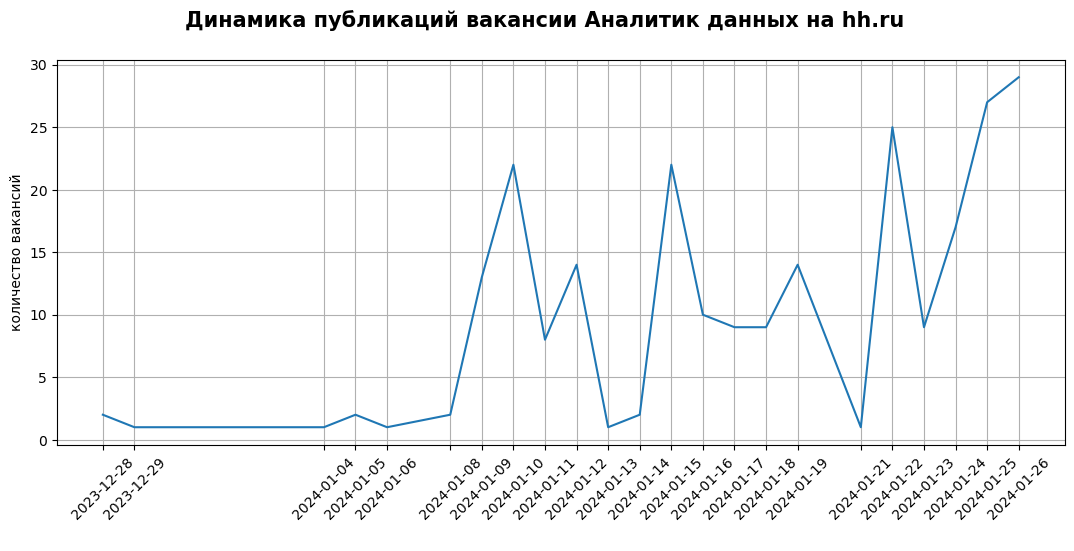

In [44]:
plt.figure(figsize=(13, 5))
ax = sns.lineplot(data=data_for_lineplot, x='date', y='name')
ax.set(xticks=data_for_lineplot.date.values)
plt.suptitle('Динамика публикаций вакансии Аналитик данных на hh.ru', fontsize=15, fontweight='bold')
plt.ylabel('количество вакансий', fontsize=10)
plt.xlabel(' ', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True)

С 08 января 2024 года наблюдается рост количества опубликованных вакансий: прошли новогодние каникулы. Также спады наблюдаются в выходные дни.

Максимальное количество вакансий (более 20 в день) опубликованы:
- 10 января (22 вакансии) - среда, второй рабочий день года;
- 15 января (22 вакансии) - понедельник;
- 22 января (25 вакансий) - понедельник;
- 26 января (30 вакансий) - пятница.

### Размер зарплаты.

Создадим срез данных для анализа сведений по заплате.

In [45]:
salary = hh_parsing_vacancies.loc[hh_parsing_vacancies['salary_total'] != -100]

In [46]:
salary.T

,0,4,5,7,8,15,16,18,20,23,...,154,161,166,176,184,205,221,223,231,239
name,Аналитик данных от 80000 ₽ до вычета налогов,Аналитик данных от 100000 до 200000 ₽ до ...,Аналитик данных от 50000 ₽ на руки,Аналитик данных от 260000 до 300000 ₽ до ...,Аналитик данных/бизнес аналитик до 80000 ₽ на...,Аналитик данных от 70000 до 95000 ₽ на руки,Аналитик (качество данных) до 108000 ₽ на руки,Аналитик базы данных от 92000 до 100280 ₽ ...,Аналитик данных от 130000 до 150000 ₽ до ...,Аналитик данных на маркетплейсах/аналитик BI о...,...,Аналитик данных/Data analyst (фармацевтическое...,Маркетолог-аналитик данных фарм от расли от 8...,Аналитик данных от 110000 до 150000 ₽ на руки,Аналитик данных до 300000 ₽ на руки,Бизнес аналитик (аналитик данных) от 60000 ₽ ...,Начинающий аналитик / Специалист по сбору и об...,Аналитик данных от 45000 до 50000 ₽ на руки,Аналитик данных по направлению взыскания (моде...,BI - разраб от чик (аналитик данных) до 20000...,Аналитик баз данных от 100000 ₽ до вычета н...
salary,NaN,NaN,от 50000 ₽ на руки,NaN,до 80000 ₽ на руки,от 70000 до 95000 ₽ на руки,до 108000 ₽ на руки,NaN,NaN,NaN,...,до 130000 ₽ на руки,от 80000 ₽ на руки,от 110000 до 150000 ₽ на руки,до 300000 ₽ на руки,от 60000 ₽ на руки,NaN,от 45000 до 50000 ₽ на руки,NaN,NaN,NaN
experience,1–3 года,3–6 лет,1–3 года,3–6 лет,1–3 года,3–6 лет,1–3 года,1–3 года,1–3 года,3–6 лет,...,1–3 года,1–3 года,1–3 года,1–3 года,не требуется,не требуется,не требуется,1–3 года,1–3 года,не требуется
schedule,"Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Частичная занятость, удаленная работа","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа",...,"Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день"
skills,"['Анализ данных', 'MS PowerPoint', 'Аналитичес...","['Аналитическое мышление', 'Python', 'Математи...","['Работа с большим объемом информации', 'Excel...",NaN,"['SaaS', 'MS SQL', 'Power BI', 'Qlik-Sense', '...",['Английский\xa0— A1 — Начальный'],"['SQL', 'Python', 'MS Office']","['MS Excel', 'Работа с базами данных', 'Точнос...","['Python', 'MS PowerPoint', 'Аналитика', 'Сбор...",NaN,...,"['SQL', 'Python', 'Работа с базами данных', 'А...",NaN,NaN,"['Data Analysis', 'SQL']",NaN,"['Работа с большим объемом информации', 'Англи...","['Английский язык', 'Работа с большим объемом ...",NaN,"['SQL', 'Анализ данных', 'Power BI', 'SSAS', '...",NaN
address,"Долгопрудный, Институтский переулок, 7","Москва, Серпуховская, Партийный переулок, 1к57с1","Москва, Крестьянская застава, Павелецкая, Прол...",NaN,NaN,NaN,"Санкт-Петербург, Выборгская, Лесная, Большой С...","Москва, Сокол, Волоколамское шоссе, 1с1",NaN,NaN,...,"Москва, 2-я Звенигородская улица, 13с43",NaN,"Ростов-на-Дону, проспект Соколова, 62",NaN,NaN,NaN,"Екатеринбург, Площадь 1905 года, улица Антона ...","Москва, Люсиновская улица, 27с1Б","109316, Москва г, Волгоградский пр-кт, дом № 4...","Москва, улица Академика Опарина, 4"
vacancy_date,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Санкт-Петербурге,26 января 2024 в Москве,25 января 2024 в Москве,26 января 2024 в Москве,...,17 января 2024 в Москве,15 января 2024 в Екатеринбурге,10 января 2024 в Ростове-на-Дону,9 января 2024 в Москве,11 января 2024 в Якутске,16 января 2024 в Москве,29 декабря 2023 в Екатеринбурге,10 января 2024 в Москве,5 января 2024 в Москве,12 января 2024 в Москве
salary_total,80000,100000,50000,260000,80000,70000,108000,92000,130000,115000,...,130000,80000,110000,300000,60000,50000,

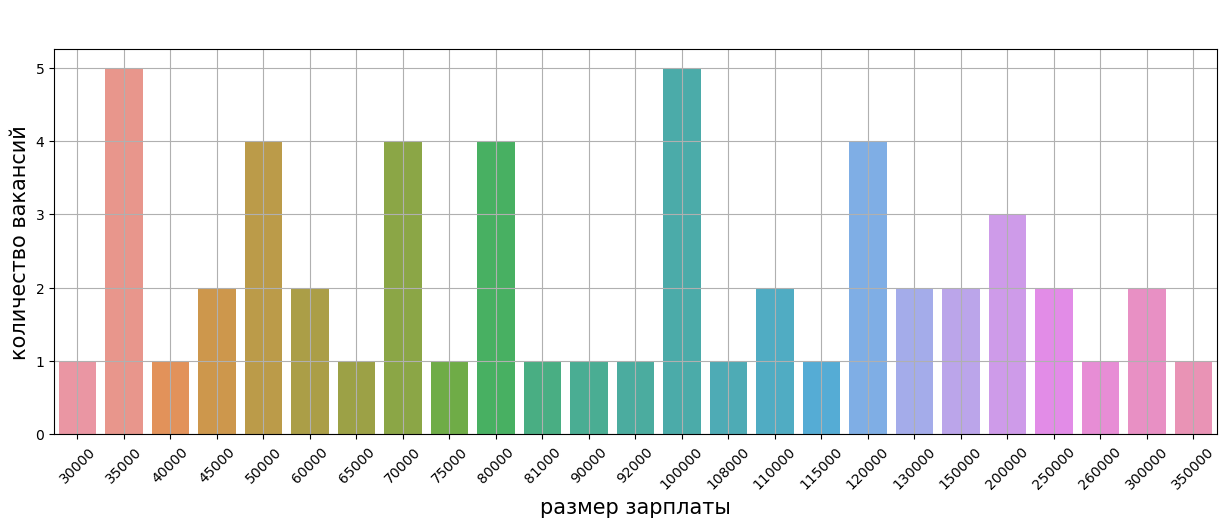

In [47]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=salary.groupby('salary_total').agg({'name':'count'}).reset_index(), x='salary_total', y='name')
plt.title(' ', fontsize = 30)
plt.xlabel('размер зарплаты', fontsize = 15)
plt.ylabel('количество вакансий', fontsize = 15)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Такой график неинформативен, категоризируем вакансии по диапазонам зарплат.

In [48]:
def create_interval_salary(column):
    '''Функция категоризирует вакансии по диапазонам зарплат'''
    if column < 50000:
        return 'до 50 тысяч'
    elif column >= 50000 and column < 100000:
        return 'от 50 до 100 тысяч'
    elif column >= 100000 and column < 150000:
        return 'от 100 до 150 тысяч'
    elif column >= 150000 and column < 200000:
        return 'от 150 до 200 тысяч'
    elif column >= 200000 and column < 250000:
        return 'от 200 до 250 тысяч'
    elif column >= 250000 and column < 300000:
        return 'от 250 до 300 тысяч'
    elif column >= 300000 and column <= 350000:
        return 'от 300 до 350 тысяч'

In [49]:
# для предотвращения появление предупреждающего сообщения SettingWithCopy
pd.options.mode.chained_assignment = None

In [50]:
salary['interval_salary'] = salary['salary_total'].apply(create_interval_salary)

Посмотрим, как прошло создание нового столбца с диапазонами зарплат.

In [51]:
salary.T

,0,4,5,7,8,15,16,18,20,23,...,154,161,166,176,184,205,221,223,231,239
name,Аналитик данных от 80000 ₽ до вычета налогов,Аналитик данных от 100000 до 200000 ₽ до ...,Аналитик данных от 50000 ₽ на руки,Аналитик данных от 260000 до 300000 ₽ до ...,Аналитик данных/бизнес аналитик до 80000 ₽ на...,Аналитик данных от 70000 до 95000 ₽ на руки,Аналитик (качество данных) до 108000 ₽ на руки,Аналитик базы данных от 92000 до 100280 ₽ ...,Аналитик данных от 130000 до 150000 ₽ до ...,Аналитик данных на маркетплейсах/аналитик BI о...,...,Аналитик данных/Data analyst (фармацевтическое...,Маркетолог-аналитик данных фарм от расли от 8...,Аналитик данных от 110000 до 150000 ₽ на руки,Аналитик данных до 300000 ₽ на руки,Бизнес аналитик (аналитик данных) от 60000 ₽ ...,Начинающий аналитик / Специалист по сбору и об...,Аналитик данных от 45000 до 50000 ₽ на руки,Аналитик данных по направлению взыскания (моде...,BI - разраб от чик (аналитик данных) до 20000...,Аналитик баз данных от 100000 ₽ до вычета н...
salary,NaN,NaN,от 50000 ₽ на руки,NaN,до 80000 ₽ на руки,от 70000 до 95000 ₽ на руки,до 108000 ₽ на руки,NaN,NaN,NaN,...,до 130000 ₽ на руки,от 80000 ₽ на руки,от 110000 до 150000 ₽ на руки,до 300000 ₽ на руки,от 60000 ₽ на руки,NaN,от 45000 до 50000 ₽ на руки,NaN,NaN,NaN
experience,1–3 года,3–6 лет,1–3 года,3–6 лет,1–3 года,3–6 лет,1–3 года,1–3 года,1–3 года,3–6 лет,...,1–3 года,1–3 года,1–3 года,1–3 года,не требуется,не требуется,не требуется,1–3 года,1–3 года,не требуется
schedule,"Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Частичная занятость, удаленная работа","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа",...,"Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, удаленная работа","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день","Полная занятость, полный день"
skills,"['Анализ данных', 'MS PowerPoint', 'Аналитичес...","['Аналитическое мышление', 'Python', 'Математи...","['Работа с большим объемом информации', 'Excel...",NaN,"['SaaS', 'MS SQL', 'Power BI', 'Qlik-Sense', '...",['Английский\xa0— A1 — Начальный'],"['SQL', 'Python', 'MS Office']","['MS Excel', 'Работа с базами данных', 'Точнос...","['Python', 'MS PowerPoint', 'Аналитика', 'Сбор...",NaN,...,"['SQL', 'Python', 'Работа с базами данных', 'А...",NaN,NaN,"['Data Analysis', 'SQL']",NaN,"['Работа с большим объемом информации', 'Англи...","['Английский язык', 'Работа с большим объемом ...",NaN,"['SQL', 'Анализ данных', 'Power BI', 'SSAS', '...",NaN
address,"Долгопрудный, Институтский переулок, 7","Москва, Серпуховская, Партийный переулок, 1к57с1","Москва, Крестьянская застава, Павелецкая, Прол...",NaN,NaN,NaN,"Санкт-Петербург, Выборгская, Лесная, Большой С...","Москва, Сокол, Волоколамское шоссе, 1с1",NaN,NaN,...,"Москва, 2-я Звенигородская улица, 13с43",NaN,"Ростов-на-Дону, проспект Соколова, 62",NaN,NaN,NaN,"Екатеринбург, Площадь 1905 года, улица Антона ...","Москва, Люсиновская улица, 27с1Б","109316, Москва г, Волгоградский пр-кт, дом № 4...","Москва, улица Академика Опарина, 4"
vacancy_date,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Москве,26 января 2024 в Санкт-Петербурге,26 января 2024 в Москве,25 января 2024 в Москве,26 января 2024 в Москве,...,17 января 2024 в Москве,15 января 2024 в Екатеринбурге,10 января 2024 в Ростове-на-Дону,9 января 2024 в Москве,11 января 2024 в Якутске,16 января 2024 в Москве,29 декабря 2023 в Екатеринбурге,10 января 2024 в Москве,5 января 2024 в Москве,12 января 2024 в Москве
salary_total,80000,100000,50000,260000,80000,70000,108000,92000,130000,115000,...,130000,80000,110000,300000,60000,50000,

Построим график распределения количества вакансий по диапазонам зарплат.

In [52]:
# сначала создадим таблицу для графика
table_for_barplot = salary.groupby('interval_salary').agg({'name':'count'}).reset_index()\
                 .sort_values(by='name', ascending=False)

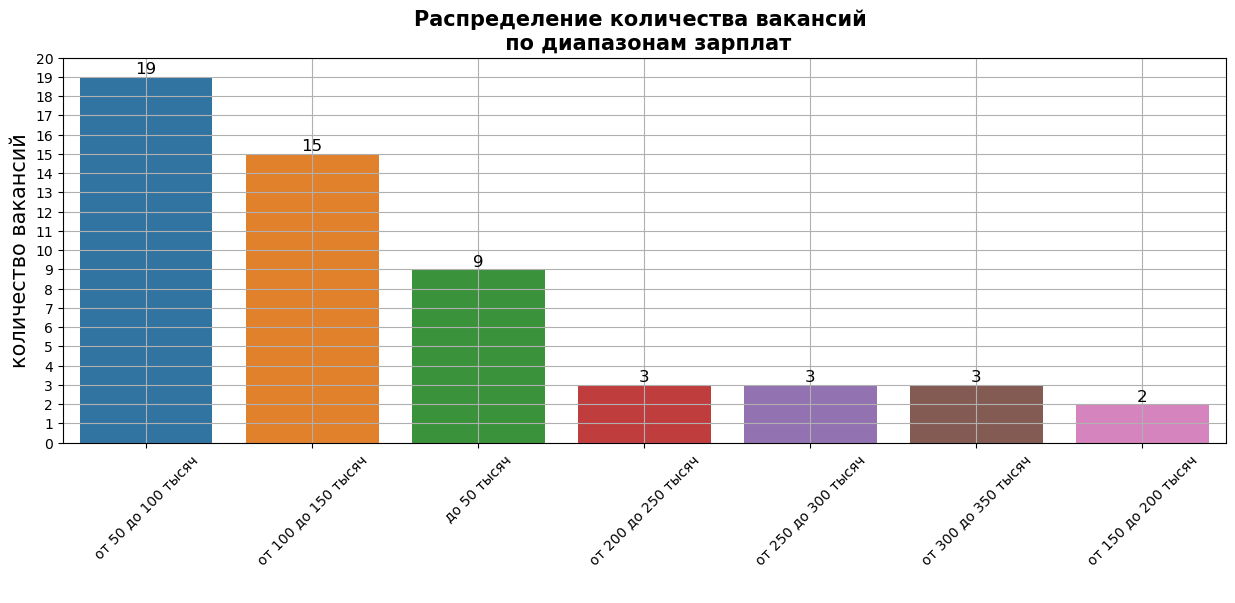

In [53]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=table_for_barplot, x='interval_salary', y='name')
plt.bar_label(ax.containers[0], size=12, label_type='edge')
plt.title('Распределение количества вакансий \n по диапазонам зарплат', fontsize=15, fontweight='bold')
plt.xlabel(' ', fontsize = 15)
plt.ylabel('количество вакансий', fontsize = 15)
y_ticks = list(range(21))
plt.yticks (ticks=y_ticks)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Получается, что в большинстве вакансий (почти в 63% случаев) работодатели предлагают зарплату от 50 до 150 тысяч:
- от 50 до 100 тысяч - в 35%;
- от 100 до 150 тысяч - в 28%.

Зарплаты до 50 тысяч предлагают в 17% вакансий.

В 16% вакансий указана зарплата свыше 200 тысяч, в 4% - от 150 до 200 тысяч.

Рассматривать, как величина предлагаемой зарплаты зависит от различных факторов будем далее при анализе каждого ключевого пункта вакансий. Для этого напишем 2 функции: формирование таблицы с агрегированными данными для графика, построение 4-х барплотов.

In [174]:
def create_table_for_plot(table,column_groupby,column_agg,list_columns):
    """Функция формирует таблицу с агрегированными данными"""
    # сначала создадим таблицу для графика
    new_table = table.groupby(column_groupby).agg({column_agg:['max','min','median','mean']}).reset_index()
    # переименуем столбцы таблицы для удобства
    new_table.columns = list_columns
    return new_table

In [177]:
def create_plots(table_for_plot,general_column):
    """Функция для построения 4-х барплотов по зарплате"""
    plt.figure(figsize=(20, 16))

    ax1 = plt.subplot(2, 2, 1)
    sns.barplot(data=table_for_plot.sort_values(by='salary_max', ascending=False), x=general_column, y='salary_max')
    plt.bar_label(ax1.containers[0], size=20, label_type='edge')
    plt.title('Максимальная зарплата', fontsize=25, fontweight='bold')
    plt.xlabel('', fontsize = 15)
    plt.ylabel('', fontsize = 15)
    plt.yticks(fontsize = 20)
    ax1.set_ylim([0, 380000])
    plt.xticks(fontsize = 20, rotation=45)
    plt.grid(True)

    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    sns.barplot(data=table_for_plot.sort_values(by='salary_min', ascending=False), x=general_column, y='salary_min')
    plt.bar_label(ax2.containers[0], size=20, label_type='edge')
    plt.title('Минимальная зарплата', fontsize=25, fontweight='bold')
    plt.xlabel('', fontsize = 15)
    plt.ylabel('', fontsize = 15)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20, rotation=45)
    plt.grid(True)

    ax3 = plt.subplot(2, 2, 3, sharey = ax1)
    sns.barplot(data=table_for_plot.sort_values(by='salary_mean', ascending=False), x=general_column, y='salary_mean')
    plt.bar_label(ax3.containers[0], size=20, label_type='edge')
    plt.title('Средняя зарплата', fontsize=25, fontweight='bold')
    plt.xlabel('', fontsize = 15)
    plt.ylabel('', fontsize = 15)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20, rotation=45)
    plt.grid(True)

    ax4 = plt.subplot(2, 2, 4, sharey = ax1)
    sns.barplot(data=table_for_plot.sort_values(by='salary_median', ascending=False), x=general_column, y='salary_median')
    plt.bar_label(ax4.containers[0], size=20, label_type='edge')
    plt.title('Медианная зарплата', fontsize=25, fontweight='bold')
    plt.xlabel('', fontsize = 15)
    plt.ylabel('', fontsize = 15)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20, rotation=45)
    plt.grid(True)

    plt.tight_layout(h_pad= 5)
    plt.show()

### Требуемый опыт работы и размер зарплаты.

Посмотрим, как распределются вакансии (их количество) в зависимости от требуемого опыта работы.

In [101]:
# создадим таблицу для графика
table_experience = hh_parsing_vacancies.groupby('experience').agg({'name':'count'}).reset_index()

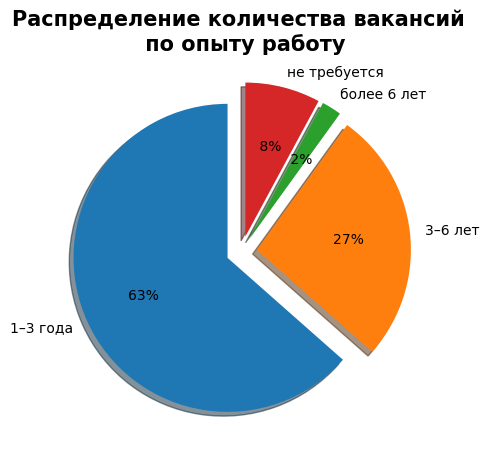

In [115]:
plt.figure(figsize=(15, 5))
ax = plt.pie(table_experience['name'], labels=table_experience['experience'],\
             startangle=90, explode=[0.1,0.1,0.1,0.1],
       shadow=True, autopct='%2.0f%%',\
             textprops={'fontsize': 10})
plt.title('Распределение количества вакансий \n по опыту работу', fontsize=15, fontweight='bold')   
plt.show()

В большинстве вакансий, 63%, требуется опыт работы "1-3 года", в 27% - "3-6 лет", в 8% - опыт работы не требуется. И, только, в 2% вакансий нужен опыт работы более 6 лет.

Посмотрим, как величина предлагаемой зарплаты зависит от требуемого опыта работы соискателя.

In [175]:
table_salary_experience = create_table_for_plot(salary,'experience','salary_total',\
                                               ['experience','salary_max','salary_min','salary_median','salary_mean'])

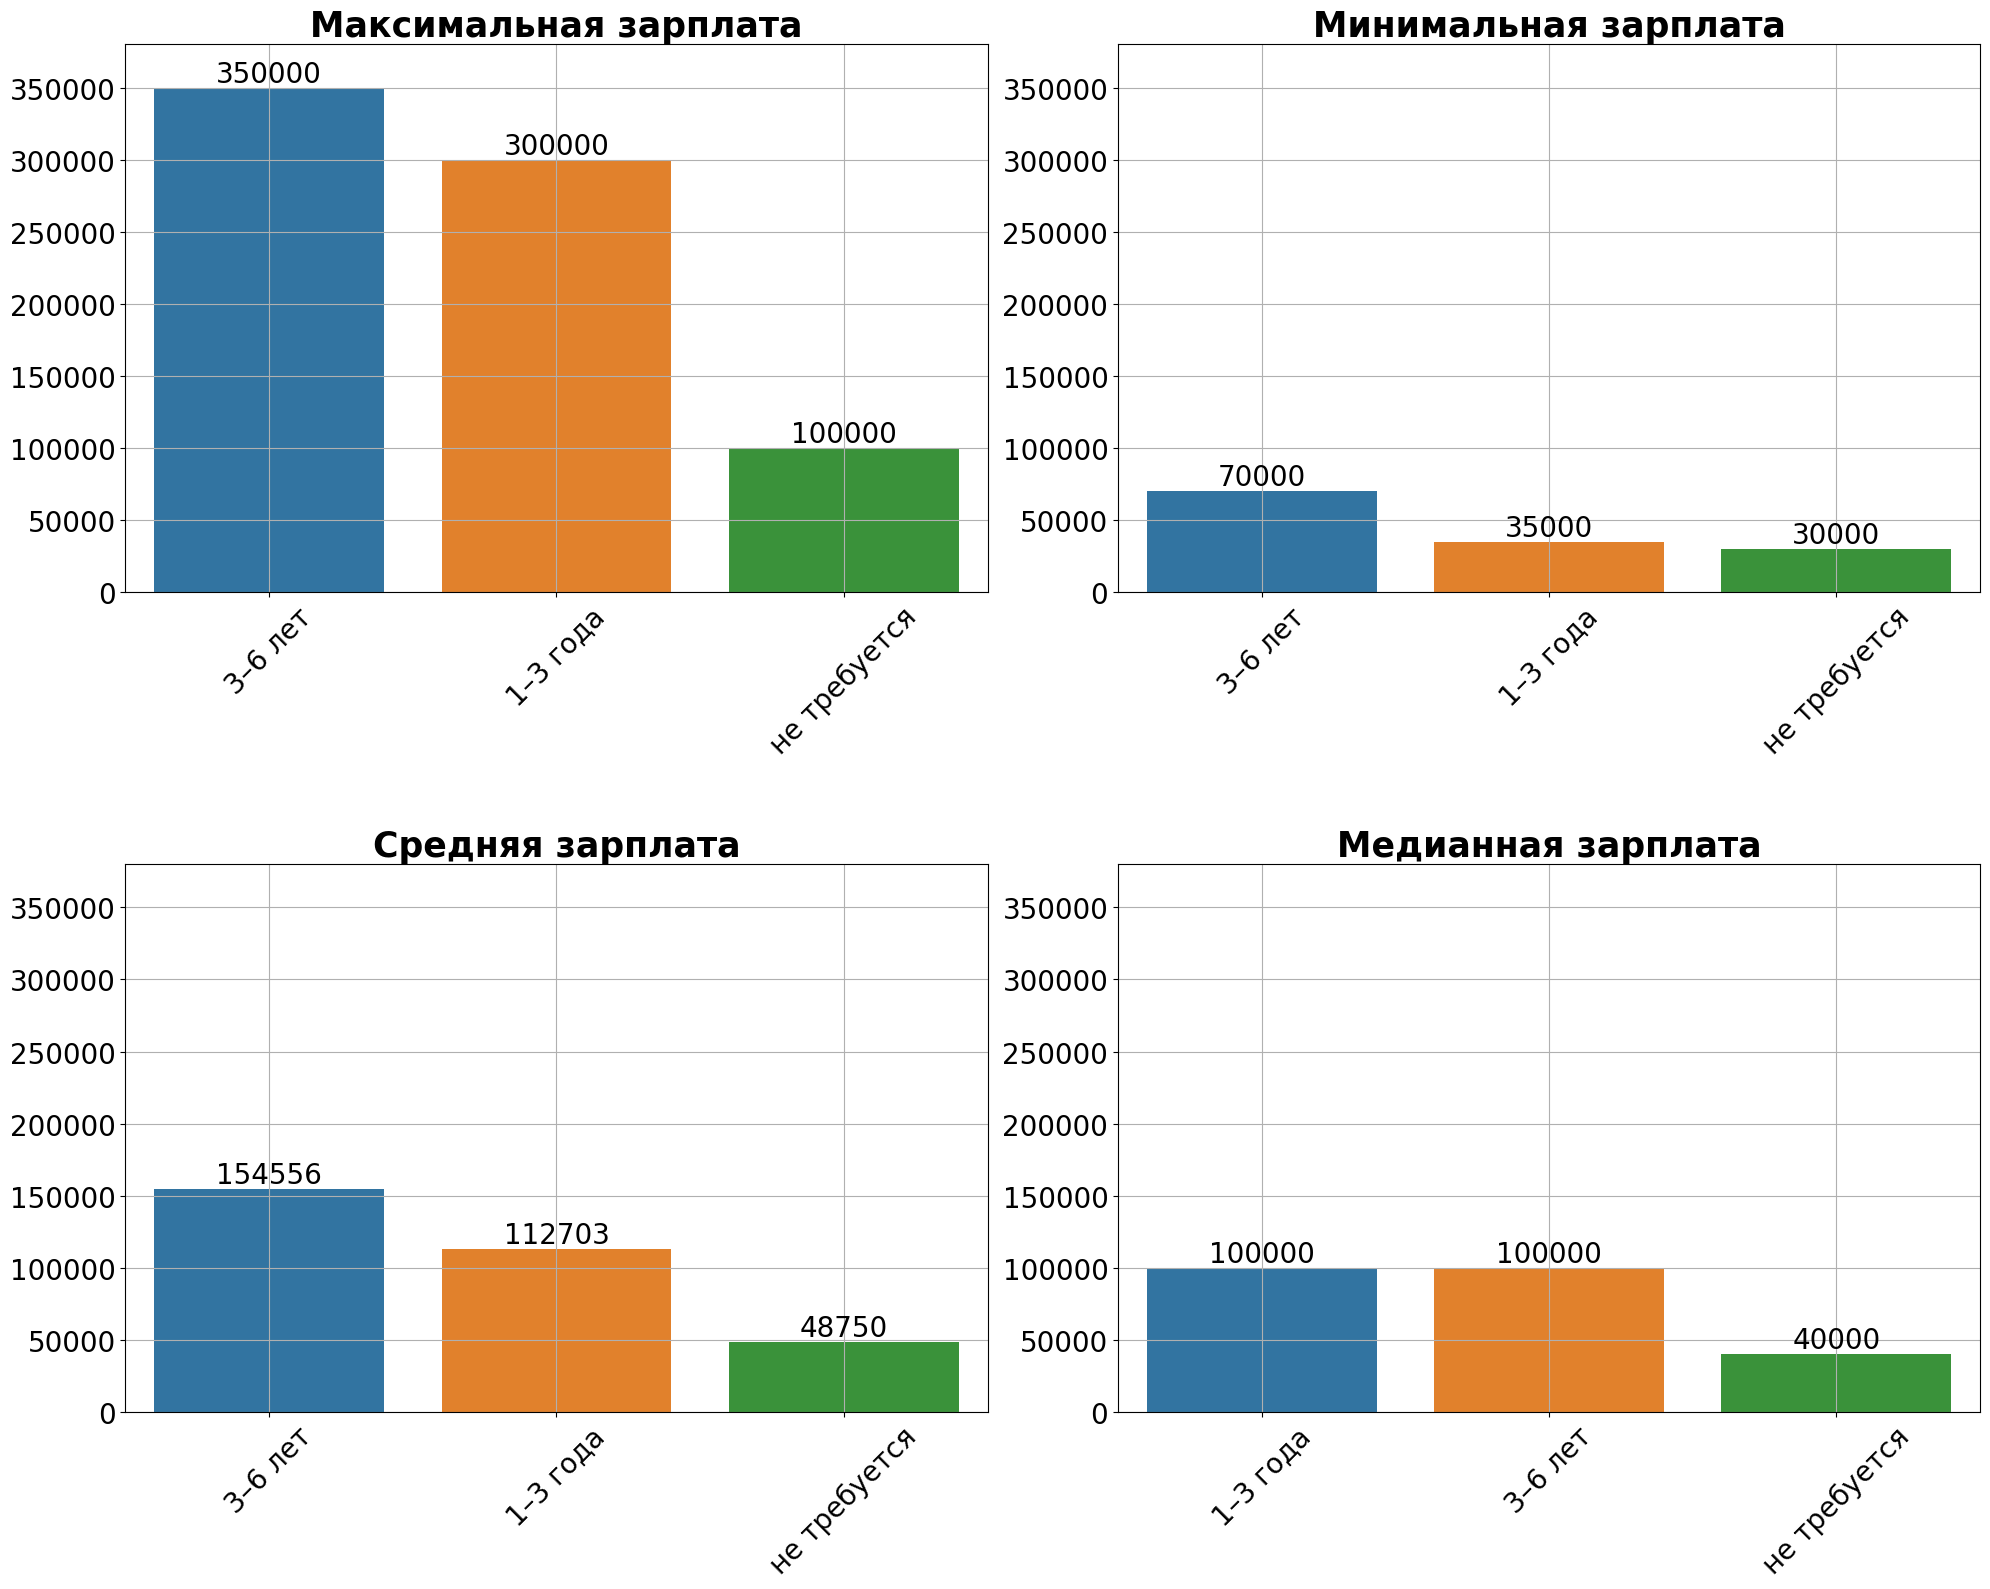

In [178]:
create_plots(table_salary_experience,'experience')

Максимальная зарплата у вакансий с опытом "3-6 лет" и "1-3 года" различается на 14% и составляет, соответственно, 350 тысяч и 300 тысяч.

У позиций, на которые не требуется опыт работы, максимальная зарплата - 100 тысяч, что более чем на 67-70% ниже, чем максимальная зарплата вакансий, где нужен опыт работы.


Минимальная зарплата у вакансий с опытом "3-6 лет" составляет 70 тысяч, что на 50-57% больше, чем минимальная зарплата на позициях с опытом "1-3 года" (35 тысяч) и там, где опыт работы не требуется (30 тысяч).


Средняя зарплата у вакансий с опытом "3-6 лет" составляет почти 155 тысяч, что на 27% выше, чем средняя зарплата на позициях с опытом "1-3 года" (113 тысяч), и на 68% выше, чем такой показатель у вакансий без опыта работы (49 тысяч).


Медианная зарплата у вакансий с опытом "3-6 лет" и "1-3 года" равна и составляет 100 тысяч, что на 60% выше, чем медианная зарплата у вакансий без опыта работы (40 тысяч).

### Полная или частичная занятость.

Посмотрим, как распределются вакансии (их количество) в зависимости от типа занятости.

In [117]:
# создадим таблицу с агрегированными данными
table_time_job = hh_parsing_vacancies.groupby('time_job').agg({'name':'count'}).reset_index()

In [119]:
table_time_job

,time_job,name
0,Полная занятость,238
1,Стажировка,2
2,Частичная занятость,1


В 99% работа требует полной занятости, только в 2 вакансиях предлагают стажировку и в 1 - частичную занятость.

Учитывая такое неравномерное распределение количества вакансий, сравнивать размеры зарплат в зависимости от типа занятости: полная/частичная занятость, стажировка, - не имеет смысла.

### Полный день или удалённая работа (график работы) и размер зарплаты.

In [122]:
# создадим таблицу с агрегированными данными
table_distant = hh_parsing_vacancies.groupby('distant').agg({'name':'count'}).reset_index()

In [123]:
table_distant

,distant,name
0,гибкий график,8
1,полный день,205
2,удаленная работа,28


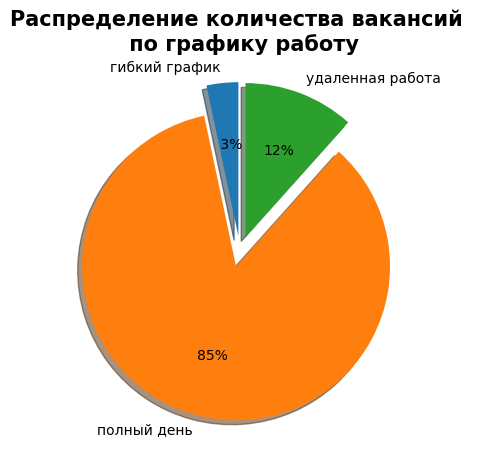

In [127]:
plt.figure(figsize=(15, 5))
ax = plt.pie(table_distant['name'], labels=table_distant['distant'],\
             startangle=90, explode=[0.1,0.1,0.1],
       shadow=True, autopct='%2.0f%%',\
             textprops={'fontsize': 10})
plt.title('Распределение количества вакансий \n по графику работу', fontsize=15, fontweight='bold')   
plt.show()

В 85% вакансий необходимо работать в офисе (полный день), в 12% - возможна удалённая работа, в 3% - гибкий график.

Посмотрим, как величина предлагаемой зарплаты зависит от предлагаемого графика работы.

In [185]:
table_salary_distant = create_table_for_plot(salary,'distant','salary_total',\
                                               ['distant','salary_max','salary_min','salary_median','salary_mean'])

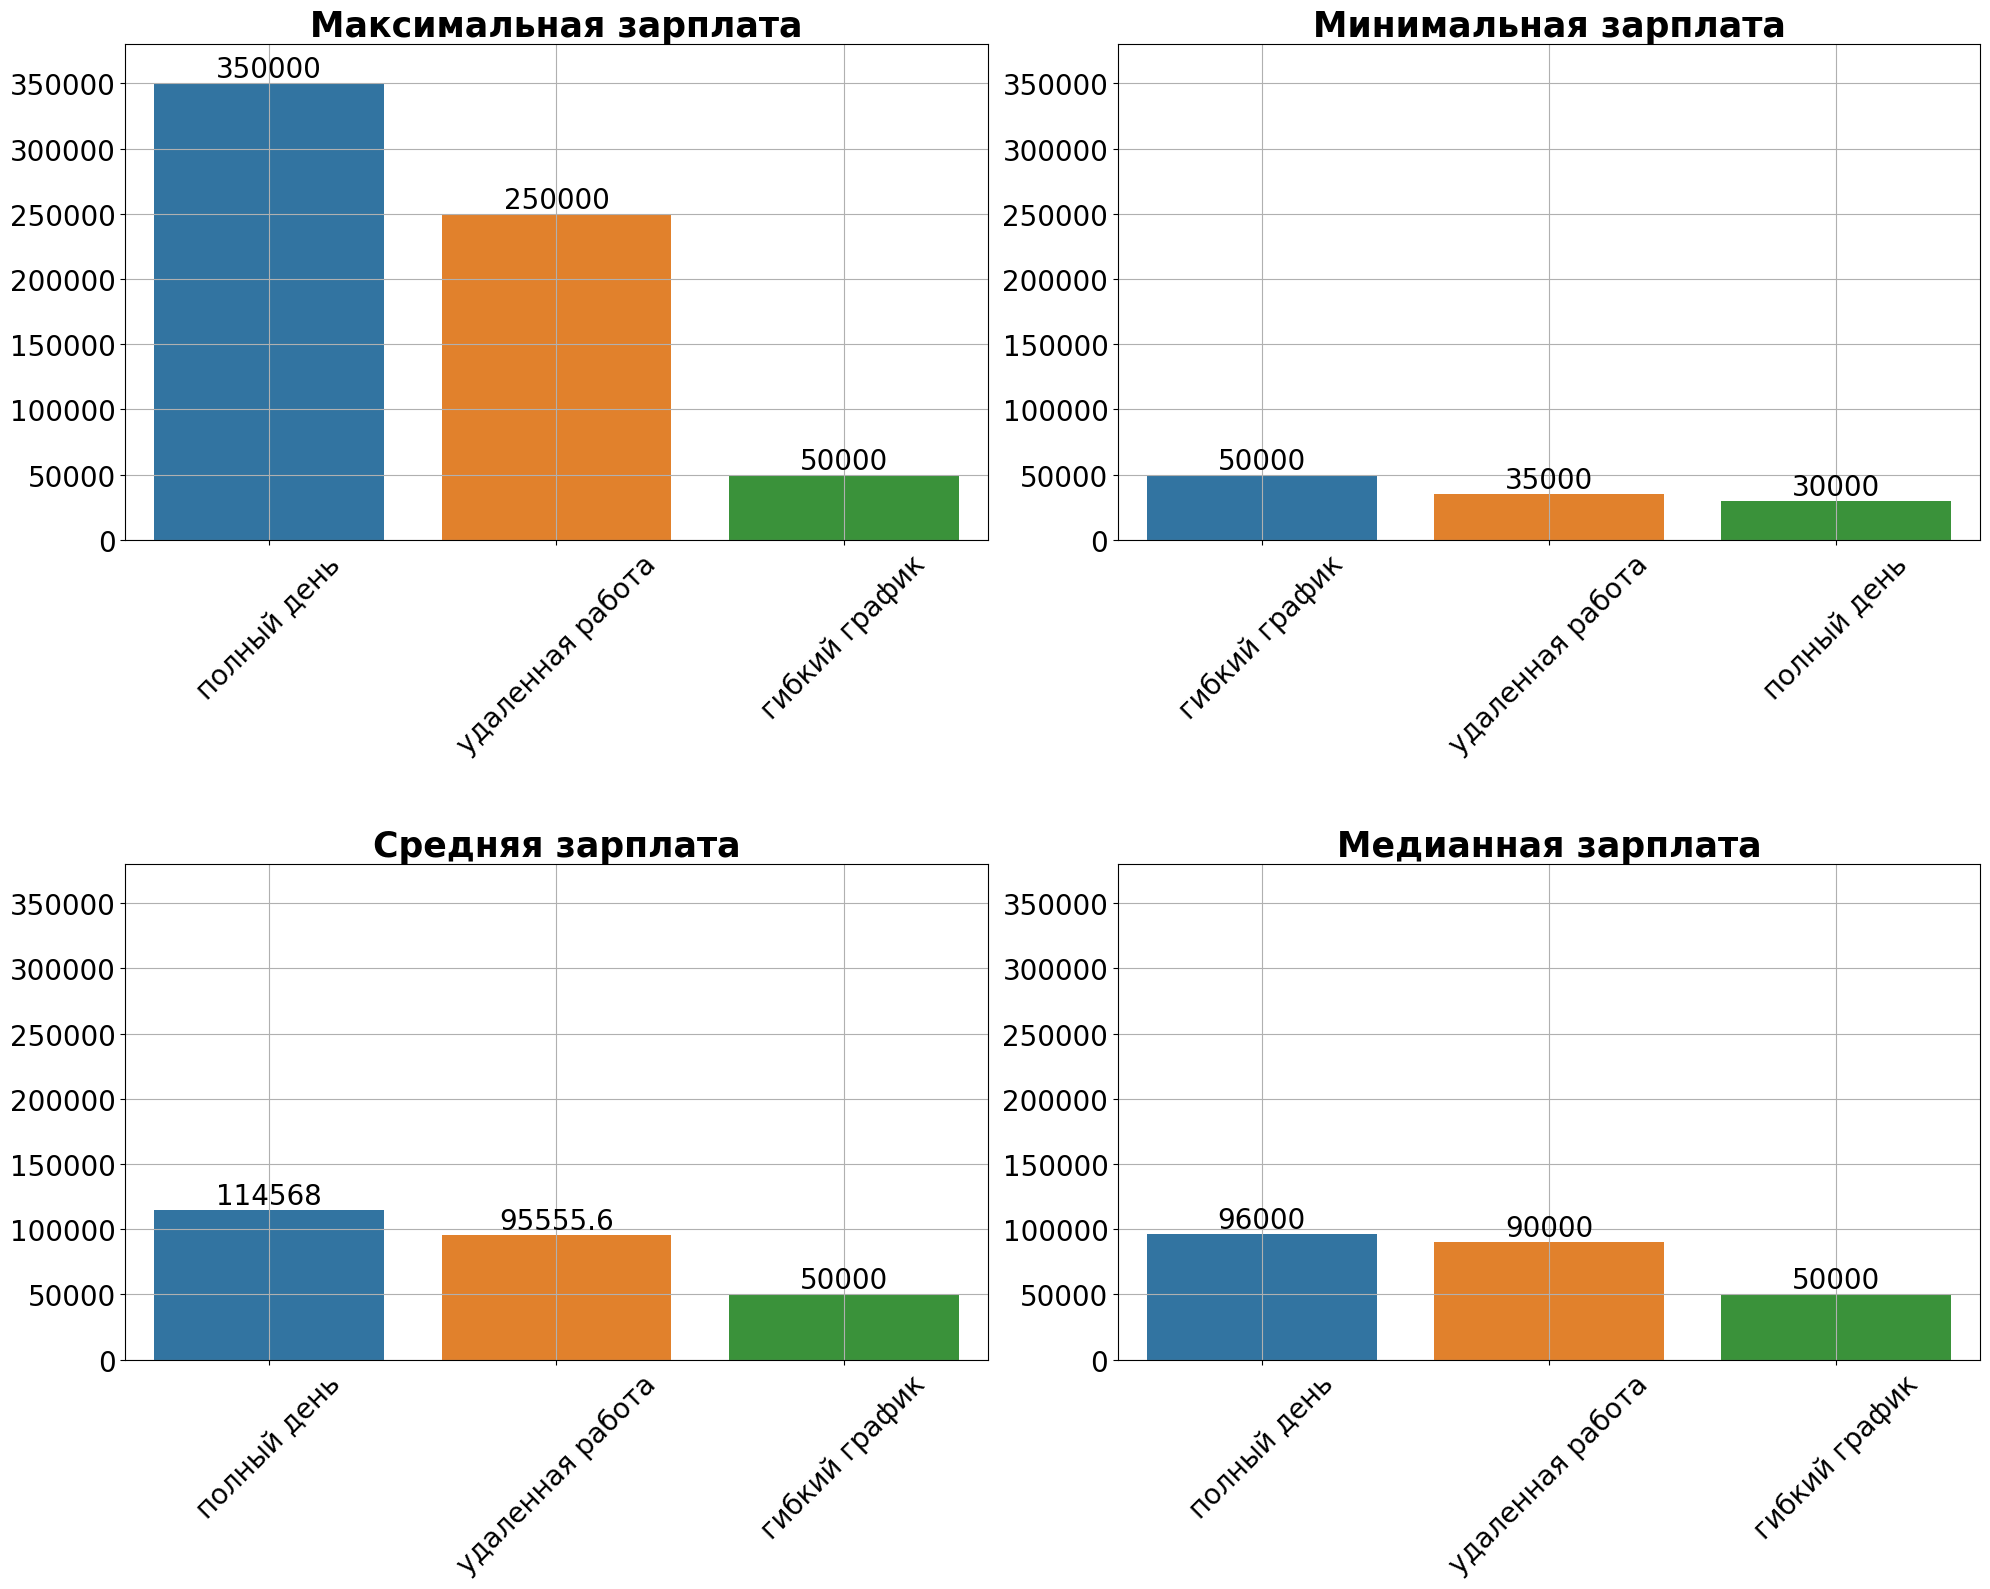

In [186]:
create_plots(table_salary_distant,'distant')

Самая высокая максимальная зарплата при полном рабочем дне - 350 тысяч, что на 29% выше, чем на удалённой работе (250 тысяч) и на 86% выше, чем при гибком графике (50 тысяч).

Самая низкая минимальная зарплата также при полном рабочем дне - 30 тысяч, что на 14% ниже, чем на удалённой работе (35 тысяч) и на 40% ниже, чем при гибком графике (50 тысяч).

Самая высокая средняя зарплата при полном рабочем дне - 115 тысяч, что на 17% выше, чем на удалённой работе (96 тысяч) и на 57% выше, чем при гибком графике (50 тысяч).

Самая высокая медианная зарплата при полном рабочем дне - 96 тысяч, что на 7% выше, чем на удалённой работе (60 тысяч) и на 48% выше, чем при гибком графике (50 тысяч).

### Как часто требуется знание SQL, Python, Excel, английского, математической статистики и размер зарплаты.

In [135]:
# создадим таблицу с агрегированными данными
table_skills = pd.DataFrame(hh_parsing_vacancies[['SQL','Python','Excel','English','Math']].sum()).reset_index()

In [137]:
# переименуем столбцы таблицы для удобства
table_skills.columns = ['skill','count']

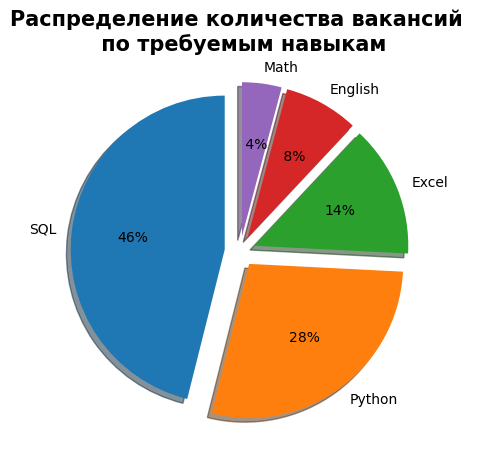

In [138]:
plt.figure(figsize=(15, 5))
ax = plt.pie(table_skills['count'], labels=table_skills['skill'],\
             startangle=90, explode=[0.1,0.1,0.1,0.1,0.1],
       shadow=True, autopct='%2.0f%%',\
             textprops={'fontsize': 10})
plt.title('Распределение количества вакансий \n по требуемым навыкам', fontsize=15, fontweight='bold')   
plt.show()

Практически в половине вакансий (46%) требуется знание SQL, в 28% - Python, в 14% - Excel, в 8% - английского языка, в 4% - математической статистики.

Посмотрим, какие сочетания навыков требуются чаще других. Рассматривать будем 3 навыка: SQL, Python, Excel. Также добавим данные по медианной зарплате.

In [194]:
SQL_Python = len(hh_parsing_vacancies.loc[(hh_parsing_vacancies['SQL'] == True)&(hh_parsing_vacancies['Python'] == True)&\
                                          (hh_parsing_vacancies['Excel'] != True)])

SQL_Excel = len(hh_parsing_vacancies.loc[(hh_parsing_vacancies['SQL'] == True)&(hh_parsing_vacancies['Python'] != True)&\
                                          (hh_parsing_vacancies['Excel'] == True)])

Python_Excel = len(hh_parsing_vacancies.loc[(hh_parsing_vacancies['SQL'] != True)&(hh_parsing_vacancies['Python'] != True)&\
                                         (hh_parsing_vacancies['Excel'] == True)])

SQL_Python_Excel = len(hh_parsing_vacancies.loc[(hh_parsing_vacancies['SQL'] == True)&(hh_parsing_vacancies['Python'] == True)&\
                                                (hh_parsing_vacancies['Excel'] == True)])

salary_median_SQL_Python = salary.loc[(salary['SQL'] == True)&(salary['Python'] == True)&(salary['Excel'] != True)]\
                                     ['salary_total'].median()
salary_median_SQL_Excel = salary.loc[(salary['SQL'] == True)&(salary['Python'] != True)&(salary['Excel'] == True)]\
                                    ['salary_total'].median()
salary_median_Python_Excel = salary.loc[(salary['SQL'] != True)&(salary['Python'] == True)&(salary['Excel'] == True)]\
                                       ['salary_total'].median()
salary_median_SQL_Python_Excel = salary.loc[(salary['SQL'] == True)&(salary['Python'] == True)&(salary['Excel'] == True)]\
                                           ['salary_total'].median()


general_skills = [{'skills':'SQL+Python','count':SQL_Python,'salary_median':salary_median_SQL_Python},
                  {'skills':'SQL+Excel','count':SQL_Excel,'salary_median':salary_median_SQL_Excel},
                  {'skills':'Python+Excel','count':Python_Excel,'salary_median':salary_median_Python_Excel},
                  {'skills':'SQL+Python+Excel','count':SQL_Python_Excel,'salary_median':salary_median_SQL_Python_Excel}]

table_general_skills = pd.DataFrame(general_skills)

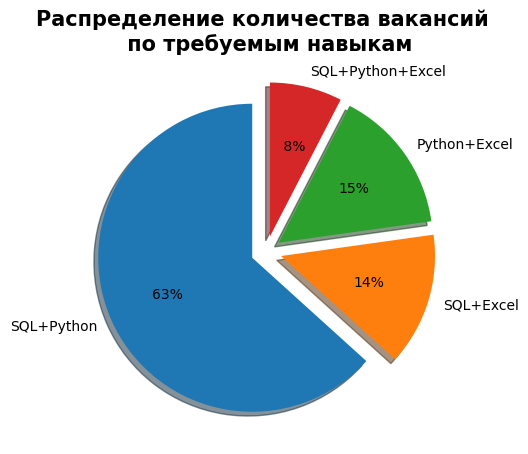

In [196]:
plt.figure(figsize=(15, 5))
ax = plt.pie(table_general_skills['count'], labels=table_general_skills['skills'],\
             startangle=90, explode=[0.1,0.1,0.1,0.1],
       shadow=True, autopct='%2.0f%%',\
             textprops={'fontsize': 10})
plt.title('Распределение количества вакансий \n по требуемым навыкам', fontsize=15, fontweight='bold')   
plt.show()

Только в 8% вакансий требуется знания всех трёх средств для обработки данных: SQL+Python+Excel.

В 63% необходимо знать Python и SQL, при этом Excel, как ключевой навык, не упоминается.

Примерно в равных долях требуется знание Python и Excel без SQL (15%) или SQL и Excel без Python (14%).

In [198]:
table_general_skills.sort_values(by='salary_median', ascending=False)

,skills,count,salary_median
0,SQL+Python,50,140000.0
2,Python+Excel,12,130000.0
1,SQL+Excel,11,80500.0
3,SQL+Python+Excel,6,NaN


Самая высокая медианная зарплата (140 тысяч) предлагают в вакансиях с требованиями навыков SQL+Python, что на 7% выше, чем в вакансиях со знаниями Python+Excel (130 тысяч) и на 43% выше, чем кандидатам со знаниями SQL+Excel.

Данные по зарплате в вакансиях со знаниями SQL+Python+Excel отсутствуют (не указаны работодателями при публикации вакансий).

### Город публикации вакансии и размер зарплаты.

In [200]:
# создадим таблицу с агрегированными данными
table_city = hh_parsing_vacancies.groupby('city').agg({'name':'count'}).reset_index()

In [201]:
# переименуем столбцы таблицы для удобства
table_city.columns = ['city','count']

In [206]:
table_city.sort_values(by='count',ascending=False).head(10)

,city,count
13,Москве,170
20,Санкт-Петербурге,18
5,Екатеринбурге,11
16,Новосибирске,5
15,Нижнем Новгороде,4
11,Краснодаре,4
3,Владивостоке,3
23,Тюмени,3
9,Казани,3
24,Чебоксарах,2


Получается, что 71% вакансий опубликован в Москве (170 вакансий), 7% - в Санкт-Петербурге (18 вакансий), 5% - в Екатеринбурге (11 вакансий), по 2% - в Новосибирске (5 вакансий), в Нижнем Новгороде (4 вакансии), в Краснодаре (4 вакансии). 11% опубликованы в иных городах (единичные вакансии).

Посмотрим, на медианные зарплаты в зависимости от группы. Будем брать те города, в которых опубликованы более одной вакансии.

In [230]:
# подготовим таблицу
table_city_salary = salary.groupby('city').agg({'name':'count','salary_total':'median'}).reset_index()

# приведём в надлежащий вид наименования городов (должны быть правильные падежи)
table_city_salary['city'] = table_city_salary['city'].replace('Москве','Москва').replace('Екатеринбурге','Екатеринбург')\
.replace('Новосибирске','Новосибирск').replace('Самаре','Самара').replace('Санкт-Петербурге','Санкт-Петербург')\
.replace('Ставрополе','Ставрополь')
table_city_salary.loc[table_city_salary['name']>1].sort_values(by='salary_total',ascending=False).head(10)

,city,name,salary_total
6,Москва,30,100000.0
3,Екатеринбург,3,80000.0
8,Новосибирск,2,67500.0
11,Самара,2,67500.0
12,Санкт-Петербург,5,35000.0
14,Ставрополь,2,35000.0


In [232]:
table_city_salary_for_plot = table_city_salary.loc[table_city_salary['name']>1].sort_values(by='salary_total',ascending=False)

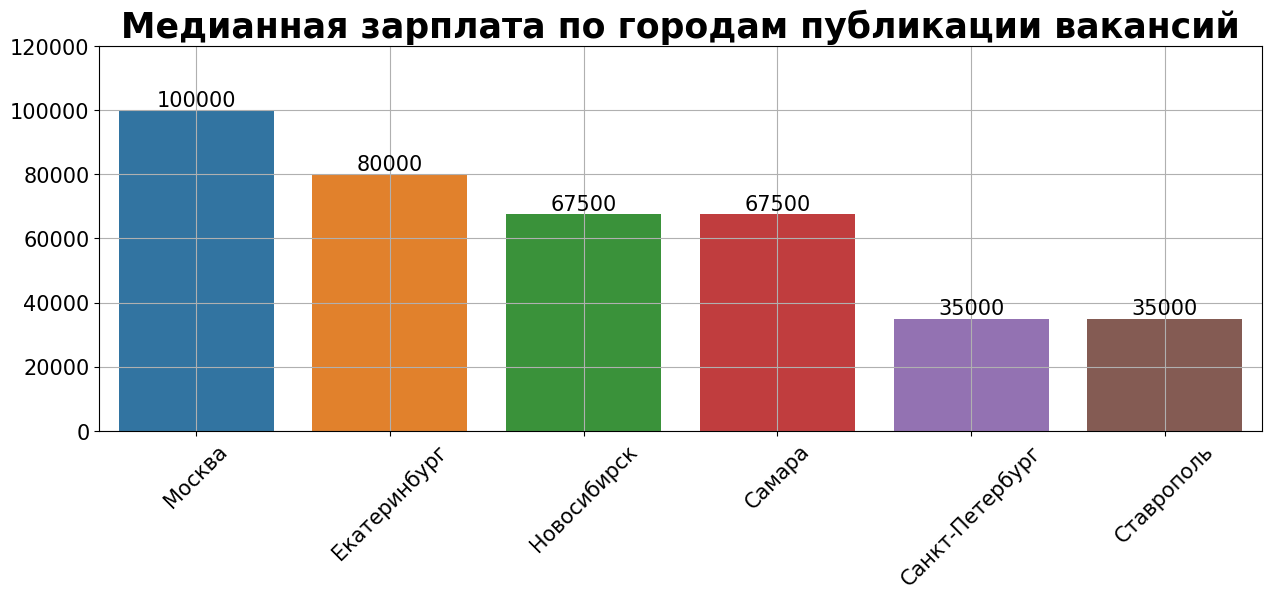

In [233]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=table_city_salary_for_plot, x='city', y='salary_total')
plt.bar_label(ax.containers[0], size=15, label_type='edge')
plt.title('Медианная зарплата по городам публикации вакансий', fontsize=25, fontweight='bold')
plt.xlabel('', fontsize = 15)
plt.ylabel('', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15, rotation=45)
plt.ylim([0,120000])
plt.grid(True)

Самая высокая медианная зарплата в Москве - 100 тысяч, что на 20% выше, чем в Екатеринбурге - 80 тысяч.

В Новосибирске и в Самаре одна и та же медианная зарплата - 67,5 тысяч, что на 33% ниже, чем в Москве.

Самая низкая медианная зарплата в Санкт-Петербурге и в Ставрополе - 35 тысяч, что на 65% ниже, чем в Москве.

## Вывод.

**1.** В результате парсинга данных о вакансиях с сайта hh.ru получены сведения о 241 вакансии на позицию "Аналитик данных".

**2.** Большинство вакансий (более 20 в день) публикуется в начале рабочей недели. С 08 января 2024 года наблюдается рост количества опубликованных вакансий: прошли новогодние каникулы. Также спады наблюдаются в выходные дни.

**3.** В 63% случаев работодатели предлагают зарплату от 50 до 150 тысяч.

**4.** В 63% требуется опыт работы "1-3 года", в 27% - "3-6 лет", в 8% - опыт работы не требуется.

**5.** Медианная зарплата у вакансий с опытом "3-6 лет" и "1-3 года" равна и составляет 100 тысяч, что на 60% выше, чем медианная зарплата у вакансий без опыта работы (40 тысяч).

**6.** В 99% работа требует полной занятости, только в 2 вакансиях предлагают стажировку и в 1 - частичную занятость.

**7.** В 85% вакансий необходимо работать в офисе (полный день), в 12% - возможна удалённая работа, в 3% - гибкий график.
Самая высокая медианная зарплата при полном рабочем дне - 96 тысяч, что на 7% выше, чем на удалённой работе (60 тысяч) и на 48% выше, чем при гибком графике (50 тысяч).

**8.** В половине вакансий (46%) требуется знание SQL, в 28% - Python, в 14% - Excel, в 8% - английского языка, в 4% - математической статистики.

Только в 8% вакансий требуется знания всех трёх средств для обработки данных: SQL+Python+Excel.

Самая высокая медианная зарплата (140 тысяч) предлагают в вакансиях с требованиями навыков SQL+Python, что на 7% выше, чем в вакансиях со знаниями Python+Excel (130 тысяч) и на 43% выше, чем кандидатам со знаниями SQL+Excel.

**9.** 71% вакансий опубликован в Москве (170 вакансий), 7% - в Санкт-Петербурге (18 вакансий), 5% - в Екатеринбурге (11 вакансий), по 2% - в Новосибирске (5 вакансий), в Нижнем Новгороде (4 вакансии), в Краснодаре (4 вакансии). 11% опубликованы в иных городах (единичные вакансии).

Самая высокая медианная зарплата в Москве - 100 тысяч, что на 20% выше, чем в Екатеринбурге - 80 тысяч.
В Новосибирске и в Самаре одна и та же медианная зарплата - 67,5 тысяч, что на 33% ниже, чем в Москве.
Самая низкая медианная зарплата в Санкт-Петербурге и в Ставрополе - 35 тысяч, что на 65% ниже, чем в Москве.
